In [1]:
import os
import shutil
import itertools
import pathlib
from PIL import Image

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
sns.set_style('whitegrid')
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data_path = 'Pneumonia_Dataset/train'
filepaths =[]
labels = []
folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
df = pd.concat([Fseries , Lseries] , axis = 1)

In [3]:
df

filepaths      label
0      Pneumonia_Dataset/train\NORMAL\IM-0115-0001.jpeg     NORMAL
1      Pneumonia_Dataset/train\NORMAL\IM-0117-0001.jpeg     NORMAL
2      Pneumonia_Dataset/train\NORMAL\IM-0119-0001.jpeg     NORMAL
3      Pneumonia_Dataset/train\NORMAL\IM-0122-0001.jpeg     NORMAL
4      Pneumonia_Dataset/train\NORMAL\IM-0125-0001.jpeg     NORMAL
...                                                 ...        ...
5211  Pneumonia_Dataset/train\PNEUMONIA\person99_vir...  PNEUMONIA
5212  Pneumonia_Dataset/train\PNEUMONIA\person9_bact...  PNEUMONIA
5213  Pneumonia_Dataset/train\PNEUMONIA\person9_bact...  PNEUMONIA
5214  Pneumonia_Dataset/train\PNEUMONIA\person9_bact...  PNEUMONIA
5215  Pneumonia_Dataset/train\PNEUMONIA\person9_bact...  PNEUMONIA

[5216 rows x 2 columns]

In [4]:
test_data_path = 'Pneumonia_Dataset/test'

filepaths =[]
labels = []
folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test = pd.concat([Fseries , Lseries] , axis = 1)
test

filepaths      label
0      Pneumonia_Dataset/test\NORMAL\IM-0001-0001.jpeg     NORMAL
1      Pneumonia_Dataset/test\NORMAL\IM-0003-0001.jpeg     NORMAL
2      Pneumonia_Dataset/test\NORMAL\IM-0005-0001.jpeg     NORMAL
3      Pneumonia_Dataset/test\NORMAL\IM-0006-0001.jpeg     NORMAL
4      Pneumonia_Dataset/test\NORMAL\IM-0007-0001.jpeg     NORMAL
..                                                 ...        ...
619  Pneumonia_Dataset/test\PNEUMONIA\person96_bact...  PNEUMONIA
620  Pneumonia_Dataset/test\PNEUMONIA\person96_bact...  PNEUMONIA
621  Pneumonia_Dataset/test\PNEUMONIA\person97_bact...  PNEUMONIA
622  Pneumonia_Dataset/test\PNEUMONIA\person99_bact...  PNEUMONIA
623  Pneumonia_Dataset/test\PNEUMONIA\person99_bact...  PNEUMONIA

[624 rows x 2 columns]

In [5]:
valid_data_path = 'Pneumonia_Dataset/val'

filepaths =[]
labels = []
folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
valid = pd.concat([Fseries , Lseries] , axis = 1)
valid

filepaths      label
0      Pneumonia_Dataset/test\NORMAL\IM-0001-0001.jpeg     NORMAL
1      Pneumonia_Dataset/test\NORMAL\IM-0003-0001.jpeg     NORMAL
2      Pneumonia_Dataset/test\NORMAL\IM-0005-0001.jpeg     NORMAL
3      Pneumonia_Dataset/test\NORMAL\IM-0006-0001.jpeg     NORMAL
4      Pneumonia_Dataset/test\NORMAL\IM-0007-0001.jpeg     NORMAL
..                                                 ...        ...
619  Pneumonia_Dataset/test\PNEUMONIA\person96_bact...  PNEUMONIA
620  Pneumonia_Dataset/test\PNEUMONIA\person96_bact...  PNEUMONIA
621  Pneumonia_Dataset/test\PNEUMONIA\person97_bact...  PNEUMONIA
622  Pneumonia_Dataset/test\PNEUMONIA\person99_bact...  PNEUMONIA
623  Pneumonia_Dataset/test\PNEUMONIA\person99_bact...  PNEUMONIA

[624 rows x 2 columns]

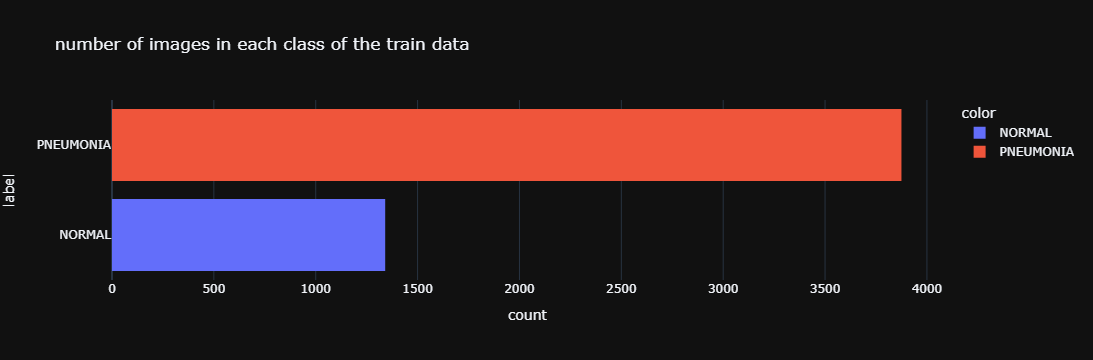

In [6]:
fig= px.histogram(data_frame= df,
           y= df['label'],
           template='plotly_dark',
           color= df['label'].values,
           title='number of images in each class of the train data')
fig.show()

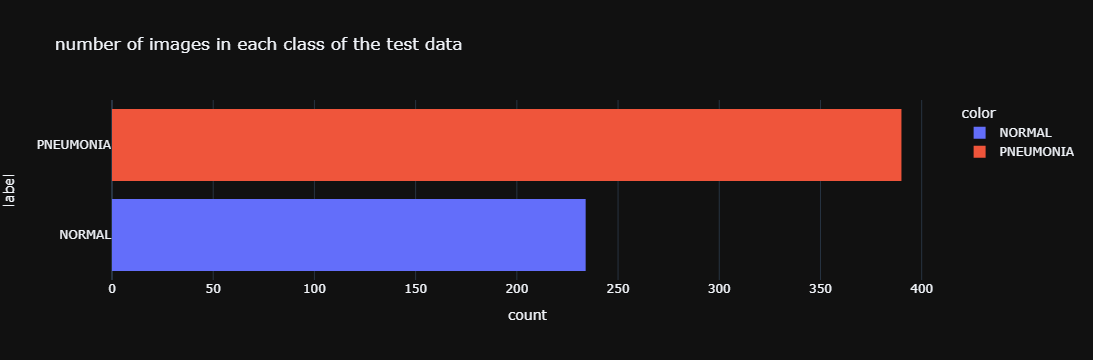

In [7]:
fig= px.histogram(data_frame= test,
           y= test['label'],
           template='plotly_dark',
           color=test['label'].values,
           title='number of images in each class of the test data')
fig.show()

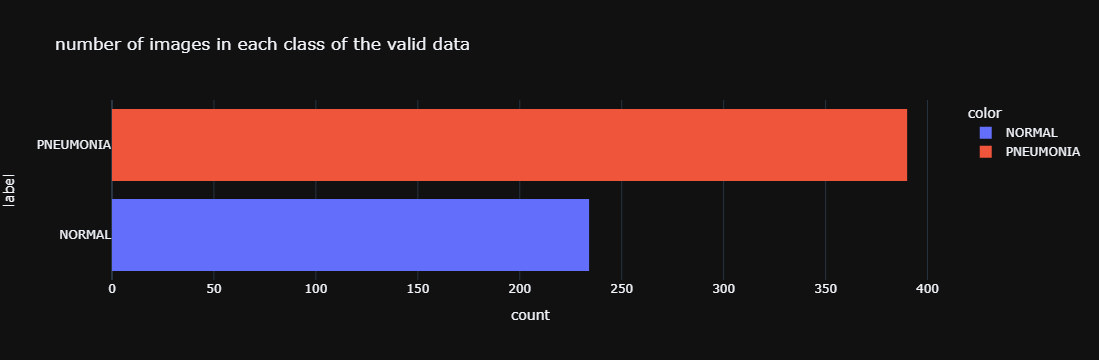

In [8]:
fig= px.histogram(data_frame= valid,
           y= valid['label'],
           template='plotly_dark',
           color=valid['label'].values,
           title='number of images in each class of the valid data')
fig.show()

In [9]:
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle= True, random_state= 42)
valid_df, test_df= train_test_split(dummy_df, train_size= 0.6, shuffle= True, random_state= 42)

In [10]:
img_size = (224 ,224)
batch_size = 16
img_shape= (img_size[0], img_size[1], 3)

def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)
valid_gen = ts_gen.flow_from_dataframe(valid_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size , 
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df , x_col= 'filepaths' , y_col = 'label' , target_size = img_size , 
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)


Found 4172 validated image filenames belonging to 2 classes.
Found 626 validated image filenames belonging to 2 classes.
Found 418 validated image filenames belonging to 2 classes.


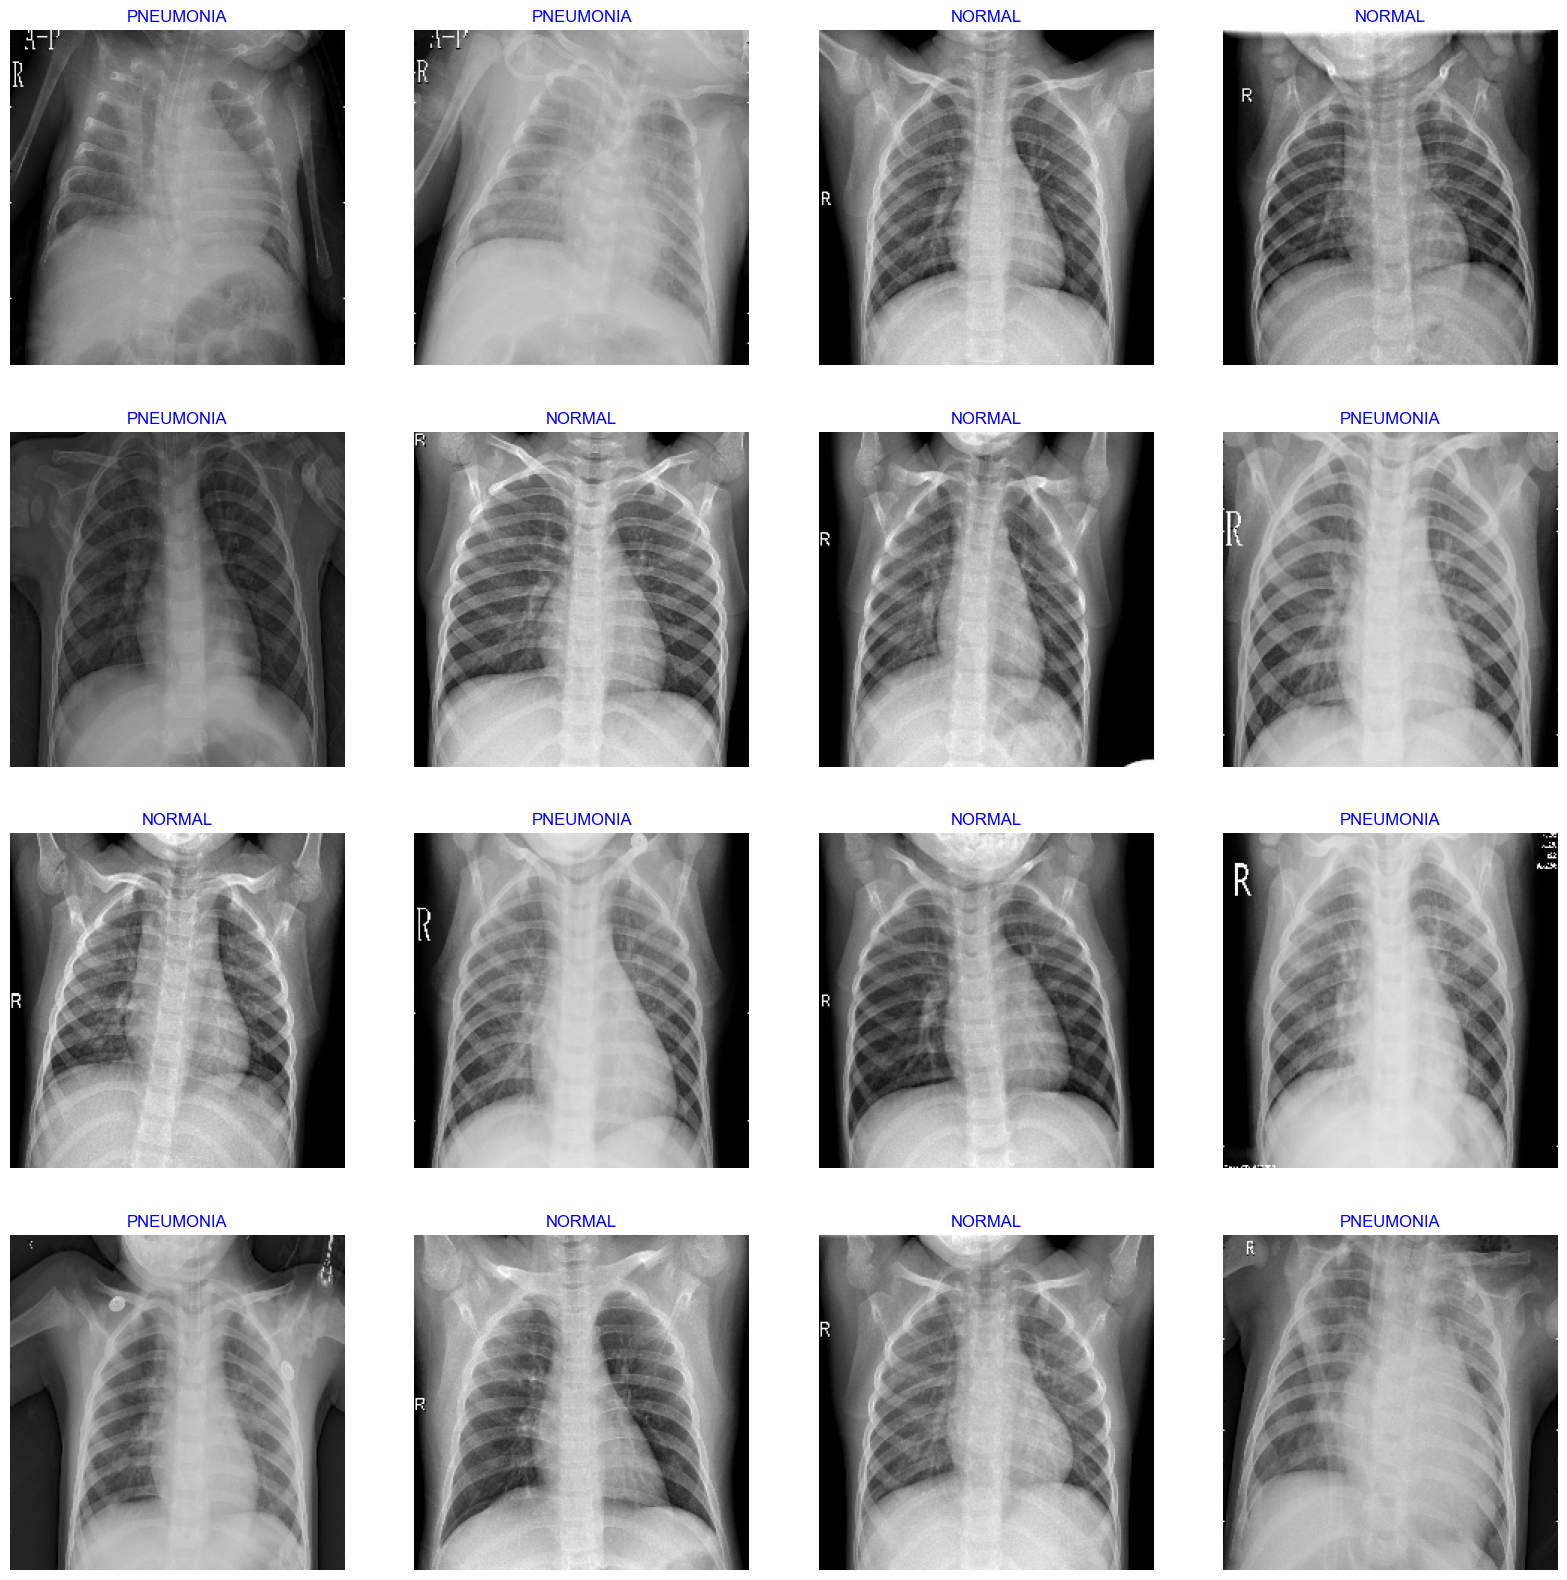

In [11]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

In [12]:
img_size = (224, 224)
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet',input_shape = img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(0.016) , activity_regularizer = regularizers.l1(0.006),bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])
model.compile(Adamax(learning_rate = 0.0001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ ?                      │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,783,535 (41.14 MB)

 Trainable params: 10,696,232 (40.80 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [13]:
Epochs = 10
history = model.fit(x= train_gen , epochs = Epochs, verbose = 1, validation_data= valid_gen,validation_steps = None , shuffle = False)

Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 1034s 4s/step - accuracy: 0.7782 - loss: 18.3244 - val_accuracy: 0.8147 - val_loss: 11.3205
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 908s 3s/step - accuracy: 0.9188 - loss: 8.1886 - val_accuracy: 0.7636 - val_loss: 7.5888
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 929s 4s/step - accuracy: 0.9127 - loss: 7.0296 - val_accuracy: 0.9393 - val_loss: 6.7350
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 887s 3s/step - accuracy: 0.8890 - loss: 6.5844 - val_accuracy: 0.9377 - val_loss: 6.3020
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 885s 3s/step - accuracy: 0.8681 - loss: 6.2213 - val_accuracy: 0.9441 - val_loss: 5.9549
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 908s 3s/step - accuracy: 0.8641 - loss: 5.8777 - val_accuracy: 0.9441 - val_loss: 5.6047
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 898s 3s/step - accuracy: 0.8671 - loss: 5.5293 - val_accuracy: 0.9521 - val_loss: 5.2548
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 907s 3s/step - accuracy: 0.8710 - loss: 5.2039 - val_a

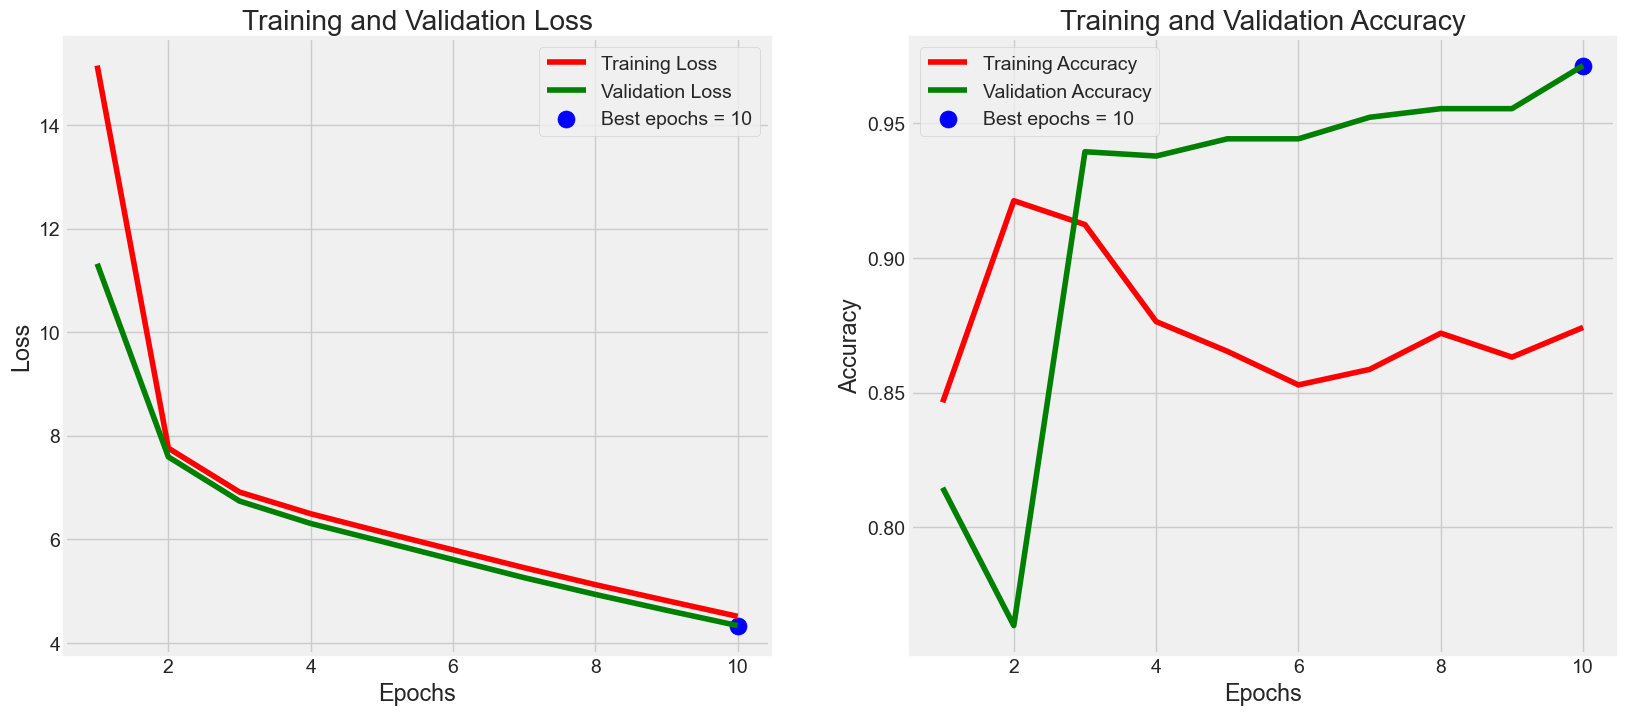

In [14]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))  
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();


In [15]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 595ms/step - accuracy: 0.9744 - loss: 4.3172
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 587ms/step - accuracy: 0.9744 - loss: 4.3304
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 607ms/step - accuracy: 0.9671 - loss: 4.3256
Train Loss:  4.325579643249512
Train Accuracy:  0.96484375
--------------------
Validation Loss:  4.331379413604736
Validation Accuracy:  0.96875
--------------------
Test Loss:  4.326344013214111
Test Accuracy:  0.96875


In [16]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds , axis = 1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 928ms/step


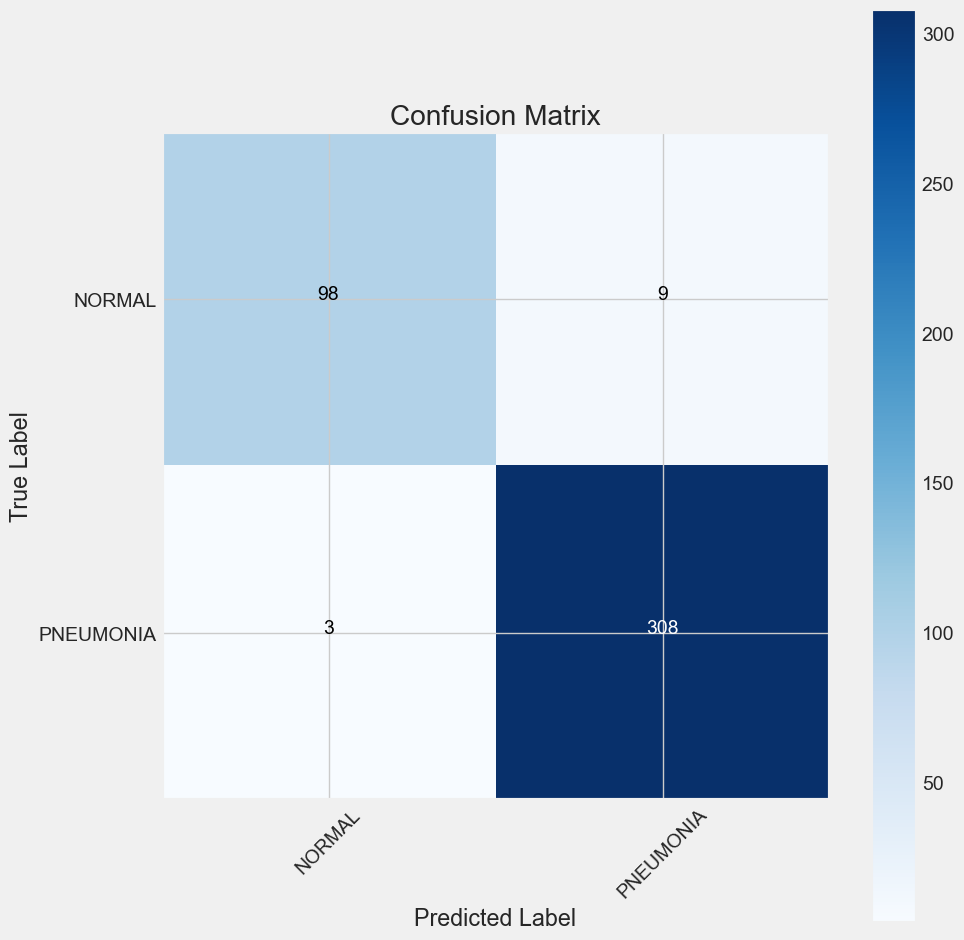

In [17]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys()) # Confusion Matrix
all_classes = np.arange(len(classes))
cm = confusion_matrix(test_labels, test_preds, labels=all_classes)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [18]:
print(classification_report(test_gen.classes, y_pred , target_names= classes )) 

              precision    recall  f1-score   support

      NORMAL       0.97      0.92      0.94       107
   PNEUMONIA       0.97      0.99      0.98       311

    accuracy                           0.97       418
   macro avg       0.97      0.95      0.96       418
weighted avg       0.97      0.97      0.97       418

